In [1]:
!pip install ucimlrepo --quiet
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu -q
!pip install scikit-learn pandas numpy matplotlib seaborn --quiet

In [3]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

RND = 42
random.seed(RND)
np.random.seed(RND)
torch.manual_seed(RND)
device = torch.device("cpu")

In [5]:
from ucimlrepo import fetch_ucirepo

ds = fetch_ucirepo(id=863)
X = ds.data.features
y = ds.data.targets

if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X)
if isinstance(y, (pd.DataFrame, pd.Series)):
    y = np.array(y).reshape(-1,)
else:
    y = np.array(y)

In [11]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_
n_classes = len(class_names)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values.astype(float))

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_enc, test_size=0.4, random_state=RND, stratify=y_enc
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RND, stratify=y_temp
)

In [10]:
def to_loader(X, y, batch_size=32, shuffle=True):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.long)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = to_loader(X_train, y_train, batch_size=32, shuffle=True)
val_loader = to_loader(X_val, y_val, batch_size=64, shuffle=False)
test_loader = to_loader(X_test, y_test, batch_size=64, shuffle=False)

def evaluate_model(model, loader):
    model.eval()
    ys = []
    ys_pred = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            preds = out.argmax(dim=1).cpu().numpy()
            ys_pred.extend(preds.tolist())
            ys.extend(yb.numpy().tolist())
    return np.array(ys), np.array(ys_pred)

def print_metrics(y_true, y_pred, labels=None):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Macro F1: ", f1_score(y_true, y_pred, average='macro'))
    print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [12]:
input_dim = X_train.shape[1]
hidden_sizes = [64, 32, 16]
dropout = 0.2

class FCNet(nn.Module):
    def __init__(self, input_dim, hidden_sizes, n_classes, dropout=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, n_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model_plain = FCNet(input_dim, hidden_sizes, n_classes, dropout=dropout).to(device)
print(model_plain)


FCNet(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=16, out_features=3, bias=True)
  )
)


In [18]:
def train_classifier(model, train_loader, val_loader, epochs=100, lr=1e-3, weight_decay=1e-5, patience=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = float('inf')
    best_state = None
    patience_cnt = 0
    history = {'train_loss':[], 'val_loss':[]}
    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        avg_train_loss = total_loss / len(train_loader.dataset)
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                total_val_loss += loss.item() * xb.size(0)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        if avg_val_loss < best_val_loss - 1e-5:
            best_val_loss = avg_val_loss
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            patience_cnt = 0
        else:
            patience_cnt += 1
        if patience_cnt >= patience:
            print(f"Early stopping at epoch {ep}")
            break
        if ep % 10 == 0 or ep==1:
            print(f"Epoch {ep} train_loss={avg_train_loss:.4f} val_loss={avg_val_loss:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, history

model_plain_trained, hist_plain = train_classifier(model_plain, train_loader, val_loader, epochs=200, lr=1e-3, patience=15)


Epoch 1 train_loss=0.4625 val_loss=0.6924
Epoch 10 train_loss=0.4496 val_loss=0.6602
Epoch 20 train_loss=0.4245 val_loss=0.6891
Early stopping at epoch 25


Accuracy: 0.729064039408867
Macro F1:  0.7270163798465684

Classification report:
               precision    recall  f1-score   support

   high risk       0.96      0.87      0.91        55
    low risk       0.63      0.89      0.74        81
    mid risk       0.72      0.42      0.53        67

    accuracy                           0.73       203
   macro avg       0.77      0.73      0.73       203
weighted avg       0.75      0.73      0.72       203



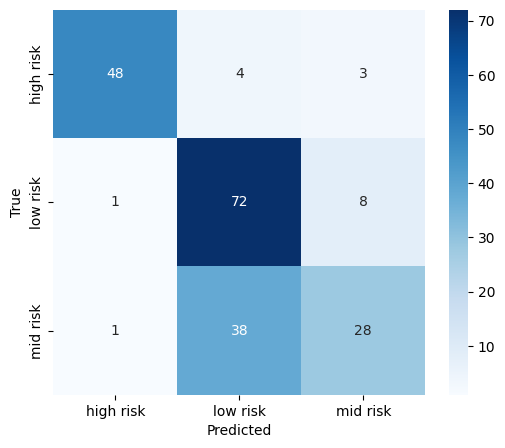

In [20]:
y_true, y_pred = evaluate_model(model_plain_trained, test_loader)
print_metrics(y_true, y_pred, labels=class_names)

In [23]:
ae_epochs = 80
ae_lr = 1e-3
ae_batch = 32

class SimpleAE(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(input_dim, bottleneck_dim), nn.ReLU())
        self.dec = nn.Sequential(nn.Linear(bottleneck_dim, input_dim))
    def forward(self, x):
        z = self.enc(x)
        xr = self.dec(z)
        return xr, z

def train_autoencoder(ae, data_X, epochs=50, batch_size=32, lr=1e-3, verbose=False):
    ae = ae.to(device)
    opt = optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    loader = to_loader(data_X, np.zeros(len(data_X)), batch_size=batch_size, shuffle=True)
    for ep in range(1, epochs+1):
        ae.train()
        total = 0.0
        for xb, _ in loader:
            xb = xb.to(device)
            xr, _ = ae(xb)
            loss = criterion(xr, xb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
        if verbose and (ep==1 or ep%20==0 or ep==epochs):
            print(f"AE epoch {ep} loss {total/len(data_X):.6f}")
    return ae

ae_models = []
activations_train = X_train.copy()
activations_val = X_val.copy()
activations_test = X_test.copy()

trained_encoders = []

for i, h in enumerate(hidden_sizes):
    ae = SimpleAE(input_dim=activations_train.shape[1], bottleneck_dim=h)
    ae = train_autoencoder(ae, activations_train, epochs=ae_epochs, batch_size=ae_batch, lr=ae_lr, verbose=True)
    ae_models.append(ae)
    ae = ae.to(device)
    ae.eval()
    with torch.no_grad():
        train_z = ae.enc(torch.tensor(activations_train, dtype=torch.float32).to(device)).cpu().numpy()
        val_z = ae.enc(torch.tensor(activations_val, dtype=torch.float32).to(device)).cpu().numpy()
        test_z = ae.enc(torch.tensor(activations_test, dtype=torch.float32).to(device)).cpu().numpy()


    linear_layer = ae.enc[0]

    enc_linear = nn.Linear(linear_layer.in_features, linear_layer.out_features)
    enc_linear.weight.data = linear_layer.weight.data.cpu().clone()
    enc_linear.bias.data = linear_layer.bias.data.cpu().clone()
    trained_encoders.append(nn.Sequential(enc_linear, nn.ReLU()))

    activations_train = train_z
    activations_val = val_z
    activations_test = test_z

print("\nPretraining finished. Number of pretrained encoders:", len(trained_encoders))


AE epoch 1 loss 0.884042
AE epoch 20 loss 0.006594
AE epoch 40 loss 0.002309
AE epoch 60 loss 0.001326
AE epoch 80 loss 0.000902
AE epoch 1 loss 0.274497
AE epoch 20 loss 0.011571
AE epoch 40 loss 0.006240
AE epoch 60 loss 0.004268
AE epoch 80 loss 0.003145
AE epoch 1 loss 0.772086
AE epoch 20 loss 0.083723
AE epoch 40 loss 0.045074
AE epoch 60 loss 0.027662
AE epoch 80 loss 0.020423

Pretraining finished. Number of pretrained encoders: 3


In [24]:
class FCNetFromEncoders(nn.Module):
    def __init__(self, encoders, n_classes, dropout=0.2):
        super().__init__()
        layers = []
        for enc in encoders:
            layers.append(enc[0])
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        last_dim = encoders[-1][0].out_features
        layers.append(nn.Linear(last_dim, n_classes))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model_pretrained = FCNetFromEncoders(trained_encoders, n_classes, dropout=dropout).to(device)
print(model_pretrained)


FCNetFromEncoders(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=16, out_features=3, bias=True)
  )
)


In [25]:
model_pt_trained, hist_pt = train_classifier(model_pretrained, train_loader, val_loader, epochs=200, lr=1e-3, patience=15)

Epoch 1 train_loss=1.3558 val_loss=1.1959
Epoch 10 train_loss=0.8473 val_loss=0.7966
Epoch 20 train_loss=0.7487 val_loss=0.6988
Epoch 30 train_loss=0.7058 val_loss=0.6720
Epoch 40 train_loss=0.6754 val_loss=0.6580
Epoch 50 train_loss=0.6556 val_loss=0.6490
Epoch 60 train_loss=0.6469 val_loss=0.6376
Epoch 70 train_loss=0.6258 val_loss=0.6293
Epoch 80 train_loss=0.6226 val_loss=0.6150
Epoch 90 train_loss=0.6134 val_loss=0.6158
Epoch 100 train_loss=0.6249 val_loss=0.6087
Epoch 110 train_loss=0.6032 val_loss=0.6016
Epoch 120 train_loss=0.5864 val_loss=0.6043
Epoch 130 train_loss=0.6027 val_loss=0.5914
Epoch 140 train_loss=0.5563 val_loss=0.5886
Epoch 150 train_loss=0.5817 val_loss=0.5920
Epoch 160 train_loss=0.5736 val_loss=0.5863
Epoch 170 train_loss=0.5826 val_loss=0.5891
Early stopping at epoch 172


Accuracy: 0.6995073891625616
Macro F1:  0.6854236536016316

Classification report:
               precision    recall  f1-score   support

   high risk       0.94      0.87      0.91        55
    low risk       0.61      0.90      0.73        81
    mid risk       0.66      0.31      0.42        67

    accuracy                           0.70       203
   macro avg       0.74      0.70      0.69       203
weighted avg       0.71      0.70      0.68       203



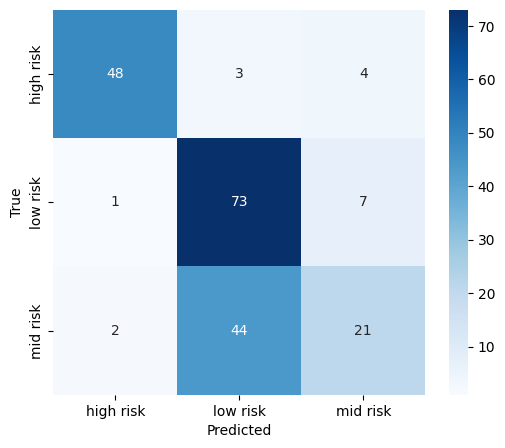

In [26]:
y_true_pt, y_pred_pt = evaluate_model(model_pt_trained, test_loader)
print_metrics(y_true_pt, y_pred_pt, labels=class_names)

In [27]:
print("Baseline (no pretraining):")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Macro F1:", f1_score(y_true, y_pred, average='macro'))
print()
print("With pretraining:")
print("Accuracy:", accuracy_score(y_true_pt, y_pred_pt))
print("Macro F1:", f1_score(y_true_pt, y_pred_pt, average='macro'))

Baseline (no pretraining):
Accuracy: 0.729064039408867
Macro F1: 0.7270163798465684

With pretraining:
Accuracy: 0.6995073891625616
Macro F1: 0.6854236536016316
